# CNN using Tensorflow Keras on MRI Image Data - failed attempt (memory out)

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

## Setup

### General Imports

In [1]:
import nibabel.freesurfer.mghformat as mgh

from tqdm.notebook import tqdm

import os, sys, shutil

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
pd.set_option('display.max_colwidth', None)

### Set up and test Tensorflow

In [2]:
import tensorflow as tf

In [3]:
# # Hide the gpu so that it uses CPU, because GPU has OOM
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")

In [4]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pandas 1.3.0
Num GPUs Available:  1


In [5]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# sess.as_default()

In [6]:
# tf.debugging.set_log_device_placement(True)

# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)

## Load data

### MRI
Since all the files are already transformed via the freesurfer, I don't think we'll need to do any major preprocessing like cropping, flipping, or rotating.
```
main_directory/
    control/
        mr_id_001/
            brain_image_001.mgz
            brain_image_001_transformed.mgz
            talairach_001.xfm
        mr_id_002/
            brain_image_002.mgz
            brain_image_002_transformed.mgz
            talairach_002.xfm
    dementia/
        mr_id_003/
            brain_image_003.mgz
            brain_image_003_transformed.mgz
            talairach_003.xfm
        mr_id_004/
            brain_image_004.mgz
            brain_image_004_transformed.mgz
            talairach_004.xfm
```

#### Define some flags for general use

In [7]:
# This class allows you to access dictionary items with a dot
# Gathered from here: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [8]:
FLAGS = {
    'scan_width'  : 256,
    'scan_height' : 256,
    'scan_depth'  : 256,
    'data_dir'    : '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data',
    'num_class'   : 4
}
FLAGS = dotdict(FLAGS)
print(FLAGS)

{'scan_width': 256, 'scan_height': 256, 'scan_depth': 256, 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'num_class': 4}


#### Generate the filenames
The returned filenames list will be organized as follows:
```
[[path_to_scan_1, label_for_scan_1],
 [path_to_scan_2, label_for_scan_2],
 [path_to_scan_3, label_for_scan_3],
 ...
 [path_to_scan_n, label_for_scan_n]]

```

In [9]:
def generate_filenames(labels=['control', 'dementia'], random_state=1337):
    pairs = []
    
    for label in labels:
        label_dir = os.path.join(FLAGS.data_dir, label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "transformed" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            pairs.append([img_path, i])
            
    random.Random(random_state).shuffle(pairs)
    
    m = len(pairs)
    filenames = []
    labels = np.zeros((m, 1), dtype='int32')
    
    idx = 0
    for filename, label in pairs:
        filenames.append(filename)
        labels[idx, 0] = label
        idx += 1
    
    filenames = np.array(filenames)
    return filenames, labels
        

X_filenames, y_labels = generate_filenames(random_state=1337)

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

In [10]:
# Save these to load them later, in case we need it
np.save('npy_files/X_filenames.npy', X_filenames)
np.save('npy_files/y_labels.npy', y_labels)

### Split into training and testing set

In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [12]:
X_filenames_shuffled, y_labels_shuffled = shuffle(X_filenames, y_labels, random_state=1337)

In [13]:
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(
    X_filenames_shuffled, y_labels_shuffled, test_size=.2, random_state=1337)

In [14]:
print(X_train_filenames.shape, y_train.shape)
print(">> train >> ", X_train_filenames[0], y_train[0])
print(X_test_filenames.shape, y_test.shape)
print(">> test >> ", X_test_filenames[5], y_test[5])

(817,) (817, 1)
>> train >>  /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30288_MR_d0897/OAS30288_Freesurfer50_d0897_brain_transformed.mgz [0]
(205,) (205, 1)
>> test >>  /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30479_MR_d1266/OAS30479_Freesurfer53_d1266_brain_transformed.mgz [1]


In [15]:
# Save these splitted arrays for later as well
np.save('npy_files/X_train_filenames.npy', X_train_filenames)
np.save('npy_files/y_train.npy', y_train)

np.save('npy_files/X_val_filenames.npy', X_test_filenames)
np.save('npy_files/y_val.npy', y_test)

### Testing the sets

In [23]:
(unique, counts) = np.unique(y_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 712]
 [  1 310]]
69.67% of the data is control


In [24]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 564]
 [  1 253]]
69.03% of the data is control


In [25]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 148]
 [  1  57]]
72.20% of the data is control


### Create a custom generator
Since the data is too large to fit it all into memory, we will have to read it in batches.

In [17]:
from tensorflow import keras

In [18]:
from skimage.transform import resize, rescale

In [26]:
class MRI_Data_Generator(keras.utils.Sequence):
    """
    A data generator that reads MRI data in batches, and returns their image data
    """
    
    def __init__(self, filenames, labels, batch_size):
        """
        Intializes the generator
        :param filenames: list containing the path to each MRI scan file, should be np.ndarray
        :param labels: labels associated with the scans in filenames (control, dementia), should be np.ndarray
        :param batch_size: the size of the batch
        """
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        
    def __len__(self):
        """
        Calculate the number of batches that we are supposed to produce.
        Returns a rounded-up integer of total number of filenames divided by batch size.
        """
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
        
    def __getitem__(self, idx):
        """
        Scan the data within that batch
        :param idx: the index of the batch to be selected
        """
        # Read in the items at that batch index
        # Since these two arrays are np arrays, we don't have to worry about index_out_of_bounds
        batch_X = self.filenames[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_y = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]
        
        # Data preprocessing
        def normalize(volume):
            """ Normalize the volume, scaling it to [0, 1] instead of [0, 255] """
            min = 0.0
            max = 255.0
            volume[volume < min] = min
            volume[volume > max] = max
            volume = (volume - min) / (max - min)
            volume = volume.astype("float32")
            return volume

        def scale(volume):
            """ Reduce the volume from (256,256,256) to (128,128,128) """
            return resize(volume, (96,96,96))
            # return rescale(volume, 0.5)
        
        # print(f'Currently reading in batch {idx}')
        
        batch_X_data = []
        for filename in batch_X:
            rem_fs = filename[:filename.rfind("/")]
            rem_fs = rem_fs[rem_fs[:rem_fs.rfind("/")].rfind("/")+1:]
#             print(f'Currently reading in batch {idx}: {rem_fs}')
            
            MRI_orig = mgh.load(filename)
            volume = MRI_orig.get_fdata()
            volume = normalize(volume)
            volume = scale(volume)
            batch_X_data.append(volume)
        
        np_res_X = np.array(batch_X_data)
        np_res_y = np.array(batch_y)
        # print(f'Shapes: x - {np_res_X.shape}, y - {np_res_y.shape}')
        return np_res_X, np_res_y

In [27]:
X_test_gen = []
y_test_gen = []
ctrls = 0
demes = 0
for i, label in enumerate(y_train):
    if ctrls >= 2 and demes >= 2:
        break
    if label == 0 and ctrls < 2:
        X_test_gen.append(X_train_filenames[i])
        y_test_gen.append(y_train[i])
        ctrls += 1
    if label == 1 and demes < 2:
        X_test_gen.append(X_train_filenames[i])
        y_test_gen.append(y_train[i])
        demes += 1
        
X_test_gen = np.array(X_test_gen)
y_test_gen = np.array(y_test_gen)

In [28]:
test_gen = MRI_Data_Generator(X_test_gen, y_test_gen, 4)
batchx, batchy = test_gen.__getitem__(0)
print(">> Num of batches >> ", test_gen.__len__())  # outputs 164, which is equal to ceil(817 / 5)
print(batchx.shape, batchy.shape)
print(batchy)

>> Num of batches >>  1
(4, 96, 96, 96) (4, 1)
[[0]
 [1]
 [0]
 [1]]


In [22]:
# Parameters for graph
nrows = 3
ncols = 4

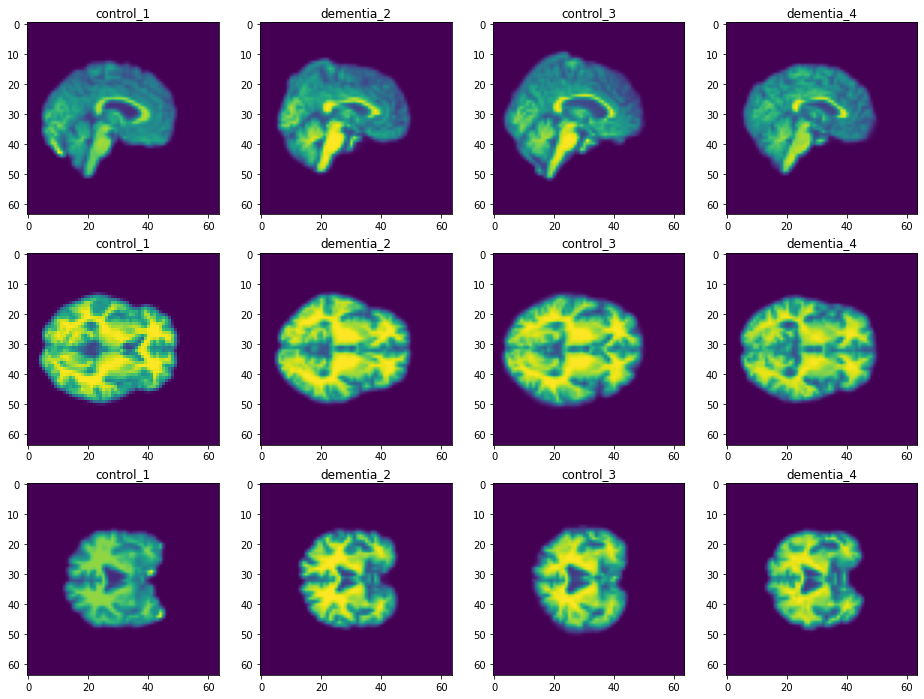

In [25]:
# Set up figure and plot it
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(4):
    sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][32,:,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][:,32,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4 + 4)
    img = batchx[i][:,:,32]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')

### Create and test our data generators

In [19]:
batch_size = 8
# batch_size = 2

training_batch_generator = MRI_Data_Generator(X_train_filenames, y_train, batch_size)
testing_batch_generator = MRI_Data_Generator(X_test_filenames, y_test, batch_size)

In [20]:
# batchx, batchy = training_batch_generator.__getitem__(0)
# print(">> Num of batches >> ", training_batch_generator.__len__())  # outputs 103, which is equal to ceil(817 / 8)

In [21]:
# print(batchx.shape, batchy.shape)
# print(batchy)

In [22]:
# batchx, batchy = testing_batch_generator.__getitem__(0)
# print(">> Num of batches >> ", testing_batch_generator.__len__()) # outputs 26, which is equal to ceil(205 / 8)

In [23]:
# print(batchx.shape, batchy.shape)
# print(batchy)

In [24]:
# delete them to save memory
# del batchx, batchy

## CNN Model
We will have one convolutional layer, a maxpooling layer, then a final dense classification layer

Resources used:
* https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130
* https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71

### Create the model

In [25]:
from tensorflow.keras import layers

In [26]:
def create_model():
    # The input is 128x128x128x1: 128x128x128 for each scan, and 1 for the channel
    inputs = keras.Input((128, 128, 128, 1))
    
    # This layer is a Conv3D layer that extracts 32 filters with a 5x5 window
    x = layers.Conv3D(filters=32, kernel_size=5, activation="relu")(inputs)
    
    # The second layer is a max-pooling layer with a 2x2 window for down sampling
    # I'm a little unsure of what max-pooling does exactly, but every resource I've seen used it after the Conv layer
    x = layers.MaxPool3D(pool_size=2)(x)
    
    # Normalizes the batch
    x = layers.BatchNormalization()(x)
    
    # Dropout layer to prevent overfitting
    # I'm also a little unsure with this, but again, every resource has used it
    x = layers.Dropout(0.25)(x)
    
    # I don't know what this does, but it doesn't work without it.
    # I got this from here: https://keras.io/examples/vision/3D_image_classification/
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected layers
    # In general, is going from 512 -> 1 too much of a sharp drop?
    x = layers.Dense(units=512, activation="relu")(x)
#     x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    # Classification/output layer
    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs, name="3d-cnn")
    return model

In [27]:
model = create_model()
model.summary()

Model: "3d-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 124, 124, 124, 32) 4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 62, 62, 62, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 32)    128       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 62, 32)    0         
_________________________________________________________________
global_average_pooling3d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               16896

In [28]:
# model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

### Train the model

In [30]:
history = model.fit(
                training_batch_generator,
                steps_per_epoch = int(X_train_filenames.shape[0] // batch_size),  # samples = batch_size * steps
                epochs = 10,
                verbose = 1,
                validation_data = testing_batch_generator,
                validation_steps = int(X_test_filenames.shape[0] // batch_size))  # samples = batch_size * steps

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[8,124,124,124,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/3d-cnn/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-30-c7e657359a77>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1132]

Function call stack:
train_function
